# Solving the TSP using Self-organizing Map (SOM)

#### Requirements  

MiniSom==2.3.1
<br> tsplib95==0.7.1
<br> requests==2.28.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import requests
import tsplib95
# import io
from minisom import MiniSom
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Load TSP instance

Data is available in Appendix B of the book's GitHub repo and can be read directly using URL begins with raw. The following instances are available in this folder:

| Intsnace     | Country | # of cities | Optimal length |
| --- | --- | --- | --- |
| fi10639.tsp | Finland | 10639 | 520,527 |
| it16862.tsp | Italy | 16,862 | 557,315 |
| qa194.tsp | Qatar | 194 | 9352 |
| uy734.tsp |Uruguay | 734 | 79114 |

More TSP instances are available at <a href="https://www.math.uwaterloo.ca/tsp/world/countries.html">National Traveling Salesman Problems</a>.

In [2]:
url ='https://raw.githubusercontent.com/Optimization-Algorithms-Book/Code-Listings/256207c4a8badc0977286c48a6e1cfd33237a51d/Appendix%20B/data/TSP/'
tsp='qa194.tsp' # TSP instance

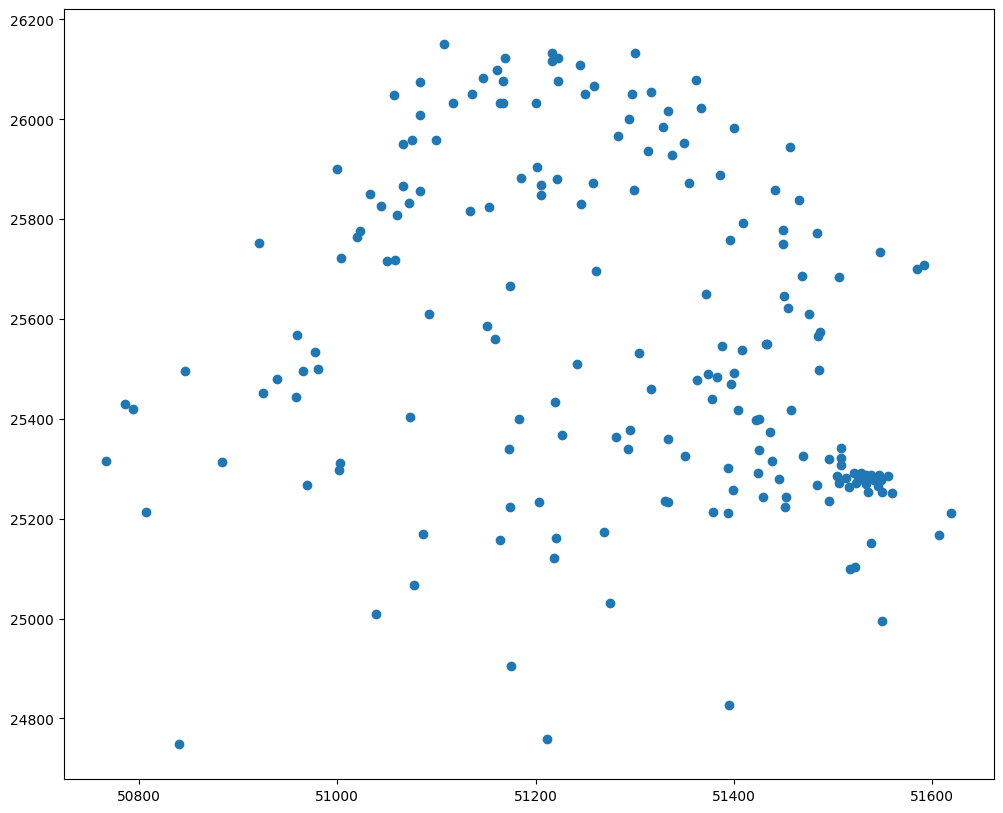

In [3]:
response = requests.get(url+tsp)
response.raise_for_status()  # Ensure we got an OK response
problem_text = response.text
problem = tsplib95.parse(problem_text)

cities=problem.node_coords
city_count = len(cities)
# Get the x (longitude) and y (latitude) 2D coordinates for each city
x = [city[1][1] for city in cities.items()]
y = [city[1][0] for city in cities.items()]
points = np.array([x,y]).T
plt.figure(figsize=(12,10))
plt.scatter(x, y)

### Train SOM

In [4]:
N_neurons = city_count

# Create a self-organizing map with 1xN_neurons grid
som = MiniSom(1, N_neurons, 2, sigma=6, learning_rate=.7,
              neighborhood_function='gaussian', random_seed=0)
# Initialize weights
som.random_weights_init(points)
# Train the SOM
som.train(points, 20000, verbose=False, random_order=False)

### Run SOM to solve the TSP

In [5]:
max_iter = 20000 # Number of iterations

paths_x = [] # List to store x coordinates per iteration
paths_y = [] # List to store y coordinates per iteration
route_lengths = []  # List to store route length per iteration

for i in tqdm(np.arange(max_iter)):
    i_point = i % len(points)
    som.update(points[i_point], som.winner(points[i_point]), i, max_iter)
    visit_order = np.argsort([som.winner(p)[1] for p in points])
    visit_order = np.concatenate((visit_order, [visit_order[0]]))
    paths_x.append(points[visit_order][:, 0])
    paths_y.append(points[visit_order][:, 1])

    # Calculate route length and store in route_lengths list
    total_distance = 0
    for j in range(len(visit_order) - 1):
        total_distance += np.linalg.norm(points[visit_order[j]] - points[visit_order[j + 1]])
    route_lengths.append(total_distance)

100%|██████████| 20000/20000 [04:59<00:00, 66.78it/s]


### Plot the route length per iteration

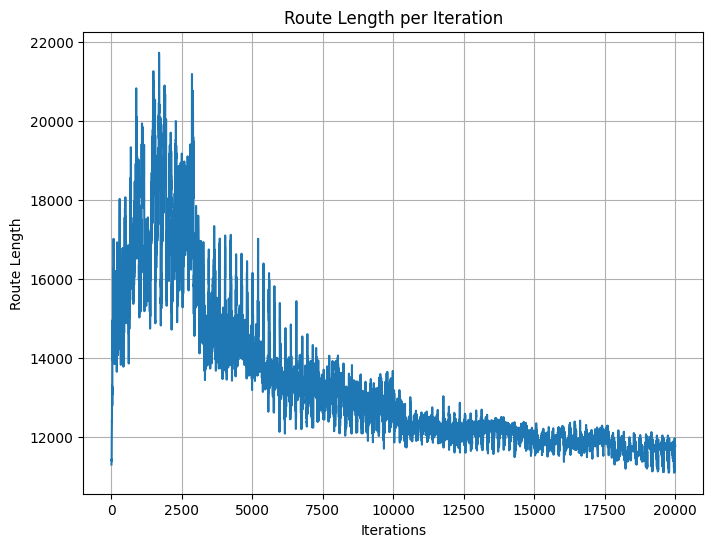

<Figure size 640x480 with 0 Axes>

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(range(max_iter), route_lengths)
plt.xlabel('Iterations')
plt.ylabel('Route Length')
plt.title('Route Length per Iteration')
plt.grid(True)
plt.show()
plt.savefig('TSP_SOM.png', dpi=600)

### Function to calculate the total distance of the path

In [7]:
def calculate_total_distance(points, visit_order):
    total_distance = 0
    for i in range(len(visit_order)-1):
        total_distance += np.linalg.norm(points[visit_order[i]] - points[visit_order[i+1]])
    return total_distance

###  Function to update the animation

In [8]:
progress_bar = tqdm(np.arange(max_iter), desc="Iteration 0", unit="iteration", total=max_iter)

def update(frame):
    progress_bar.set_description(f"Iteration {frame}/{max_iter}")

    ln.set_data(paths_x[frame], paths_y[frame])
    plt.title('iteration = %d' % frame)

    if frame == (max_iter - 1):  # check if it is the last frame
        plt.savefig('output.png', dpi=300)  # save the figure
        final_order = visit_order  # the order of visits at the last frame
        final_distance = calculate_total_distance(points, final_order)
        print(f"\nFinal TSP route length: {final_distance}")
        # Plot the final route
        final_x = points[final_order][:, 0]
        final_y = points[final_order][:, 1]
        plt.plot(final_x, final_y, 'r--', label='Final Route')
        plt.legend()

    return ln,

Iteration 0:   0%|          | 0/20000 [00:00<?, ?iteration/s]

### Visualize the search progress

Please be informed that this code snippet takes long time to run.

Iteration 19999/20000:   0%|          | 0/20000 [57:45<?, ?iteration/s]


Final TSP route length: 11764.778271877152


Animation movie is 26500839 bytes, exceeding the limit of 20971520.0. If you're sure you want a large animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB).


Iteration 0/20000:   0%|          | 0/20000 [57:46<?, ?iteration/s]    

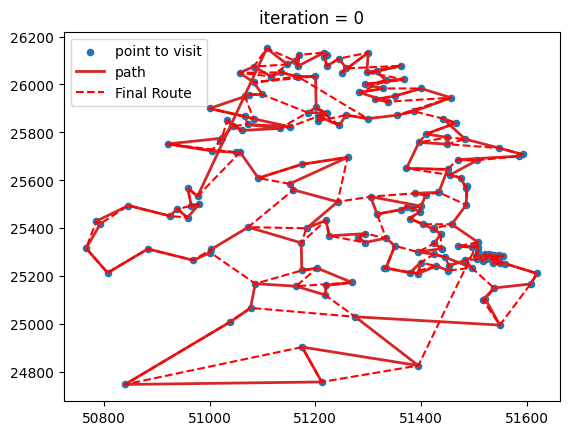

In [9]:
fig, ax = plt.subplots()
plt.scatter(x, y, label='point to visit', s=20)
ln, = plt.plot([], [], 'C3', linewidth=2, label='path')
plt.legend()

ani = FuncAnimation(fig, update, frames=np.arange(max_iter),
                    interval=10, repeat=False, blit=False)
HTML(ani.to_html5_video())